# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import zero_one_loss

%matplotlib inline

In [3]:
from utils.data_gen import compute_bayes_risk_binary, compute_bayes_risk_binary_label_shift,\
    generate_2d_example

from utils.concentrations import hoeffding_ci_lower_limit,\
    hoeffding_ci_upper_limit
from utils.concentrations import pm_bernstein_ci_upper_limit,\
    pm_bernstein_ci_lower_limit

from utils.concentrations import pm_bernstein_lower_limit, pm_bernstein_upper_limit
from utils.concentrations import pm_hoeffding_upper_limit, pm_hoeffding_lower_limit

from utils.data_gen import LDA_predictor

from utils.concentrations import betting_ci_lower_limit,betting_ci_upper_limit

In [4]:
sns.set(style="whitegrid",
        font_scale=1.4,
        rc={
            "lines.linewidth": 2,
#             "axes.facecolor": ".9",
            'figure.figsize': (12, 6)
        })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

In [5]:
legend_dict = ['$\{0\}$', '$\{1\}$']
clr1 =  np.array([193, 142, 206]) / 256
clr2 = np.array([125, 225, 125]) / 256
colors = [clr1,clr2]

color1 = np.array([244, 236, 118]) / 256
color2 = np.array([110, 200, 235]) / 256
color3 = np.array([233, 113, 183]) / 256

In [6]:
%load_ext autoreload
%autoreload 2

# Data (largely intersecting classes)

In [7]:
mu_1 = np.array([1,0])
mu_0 = np.array([-1,0])
prob_class_1 = np.linspace(0.1,0.9,20)

In [8]:
X,y = generate_2d_example(0.25, mu_0, mu_1, 1000)

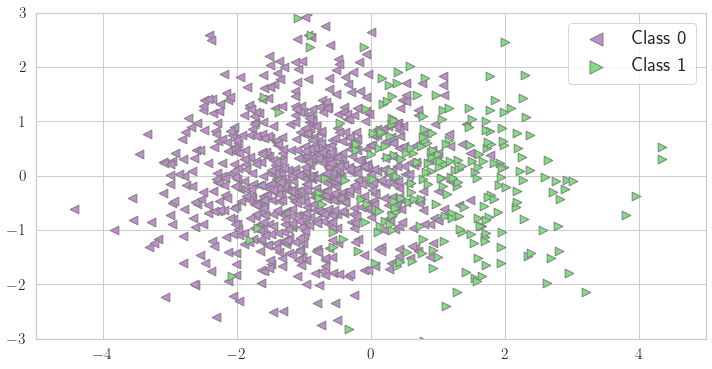

In [9]:
plt.figure(figsize=[12, 6])
plt.scatter(X[y == 0, 0],
            X[y == 0, 1],
            edgecolor="gray",
            marker='<',
            label= 'Class 0',
            s=75,
            c=colors[0].reshape(1, -1))
plt.scatter(X[y == 1, 0],
            X[y == 1, 1],
            edgecolor="gray",
            marker='>',
            label= 'Class 1',
            s=75,
            c=colors[1].reshape(1, -1))
plt.legend(loc=1, markerscale=1.5, prop={'size': 20})
plt.xlim([-5,5])
plt.ylim([-3,3])
plt.show()
# plt.savefig('img/not_well_sep_data_vis.pdf', bbox_inches='tight')

# True Bayes-risks for source and target 

In [10]:
risk_source = compute_bayes_risk_binary_label_shift(0.25, 0.25, mu_1, mu_0)[0][0]
risk_target = compute_bayes_risk_binary_label_shift(0.25, 0.75, mu_1, mu_0)[0][0]

In [11]:
compute_bayes_risk_binary(0.25,mu_1,mu_0)[0][0]

0.1270168302054692

In [12]:
risk_source

0.1270168302054692

In [13]:
print(
    ' Bayes-risk on the source: {:f} \n Risk of the Bayes-optimal rule on the target: {:f}'
    .format(risk_source, risk_target))

 Bayes-risk on the source: 0.127017 
 Risk of the Bayes-optimal rule on the target: 0.259742


# Tester

## Approximation on the source

In [14]:
mu_1 = np.array([1, 0])
mu_0 = np.array([-1, 0])
prob_class_1 = 0.25
prob_class_0 = 1 - prob_class_1
cov = np.eye(2)

eps_tol_level = 0

In [95]:
clf = LDA_predictor()

clf.mean_class_0 = mu_0
clf.mean_class_1 = mu_1
clf.class_0_prior = prob_class_0
clf.class_1_prior = prob_class_1

In [96]:
from utils.tests import Drop_tester

In [97]:
tester_hoeffding = Drop_tester()
tester_bernstein = Drop_tester()
tester_betting = Drop_tester()

tester_hoeffding.eps_tol = eps_tol_level
tester_hoeffding.source_conc_type = 'hoeffding'

tester_bernstein.eps_tol = eps_tol_level
tester_bernstein.source_conc_type = 'pm_bernstein'

tester_betting.eps_tol = eps_tol_level
tester_betting.source_conc_type = 'betting'

In [98]:
cand_number_of_samples = [
    50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750,
    800, 850, 900, 950, 1000
]
num_repeats = 1000

In [99]:
up_bounds_hoef = list()
up_bounds_bernstein = list()
up_bounds_betting = list()

In [100]:
from utils.tests import misclas_losses

In [101]:
for cur_ind, cur_sample_size in enumerate(cand_number_of_samples):
    up_bounds_hoef += [[]]
    up_bounds_bernstein += [[]]
    up_bounds_betting += [[]]
    for cur_sim in range(num_repeats):
        X_val_source, y_val_source = generate_2d_example(0.25, mu_0, mu_1, cur_sample_size)
        y_pred_val = clf.predict(X_val_source)
        ind_loss_source = misclas_losses(y_pred_val, y_val_source)
        tester_hoeffding.estimate_risk_source(ind_loss_source)
        tester_bernstein.estimate_risk_source(ind_loss_source)
        tester_betting.estimate_risk_source(ind_loss_source)
        up_bounds_hoef[cur_ind]+=[tester_hoeffding.source_rejection_threshold]
        up_bounds_bernstein[cur_ind]+=[tester_bernstein.source_rejection_threshold]
        up_bounds_betting[cur_ind]+=[tester_betting.source_rejection_threshold]

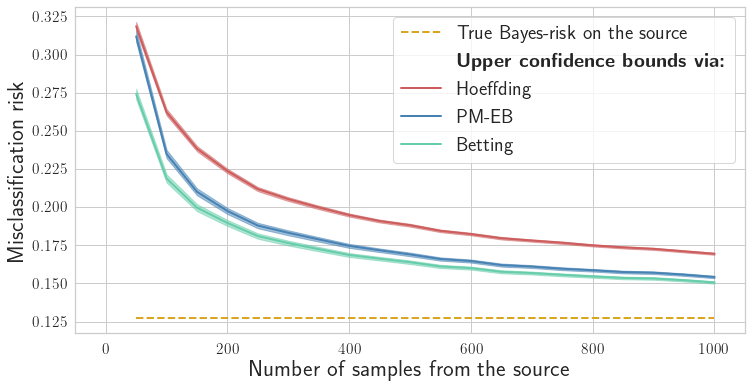

In [119]:
plt.figure(figsize=[12, 6])
# source plots
l1, = plt.plot(cand_number_of_samples,
               np.repeat(risk_source + eps_tol_level,
                         repeats=len(cand_number_of_samples)),
               label='True Bayes-risk on the source',
               linestyle='dashed',
               c='goldenrod')

# plt.plot(samples_enum,
#          np.repeat(tester_hoeffding.source_emp_risk+eps_tol_level, repeats=num_of_samples),
#          label='Estimated (source) risk', c = clr1)

l2, = plt.plot(cand_number_of_samples,
               np.mean(up_bounds_hoef, axis=1),
               label='Hoeffding',
              color='indianred')

plt.fill_between(cand_number_of_samples,
                 y1=np.mean(up_bounds_hoef, axis=1) -
                 2 * np.std(up_bounds_hoef, axis=1) / np.sqrt(num_repeats),
                 y2=np.mean(up_bounds_hoef, axis=1) +
                 2 * np.std(up_bounds_hoef, axis=1) / np.sqrt(num_repeats),
                 alpha=0.5,
              color='indianred')

l3, = plt.plot(cand_number_of_samples,
               np.mean(up_bounds_bernstein, axis=1),
               label='Upper bound, PM-EB',
              color='steelblue')

plt.fill_between(
    cand_number_of_samples,
    y1=np.mean(up_bounds_bernstein, axis=1) -
    2 * np.std(up_bounds_bernstein, axis=1) / np.sqrt(num_repeats),
    y2=np.mean(up_bounds_bernstein, axis=1) +
    2 * np.std(up_bounds_bernstein, axis=1) / np.sqrt(num_repeats),
    alpha=0.5,
              color='steelblue')

l4, = plt.plot(cand_number_of_samples,
               np.mean(up_bounds_betting, axis=1),
               label='Upper bound, Betting',
              color='mediumaquamarine')

plt.fill_between(cand_number_of_samples,
                 y1=np.mean(up_bounds_betting, axis=1) -
                 2 * np.std(up_bounds_betting, axis=1) / np.sqrt(num_repeats),
                 y2=np.mean(up_bounds_betting, axis=1) +
                 2 * np.std(up_bounds_betting, axis=1) / np.sqrt(num_repeats),
                 alpha=0.5,
              color='mediumaquamarine')

p5, = plot([0.15], marker='None', linestyle='None', label='dummy-tophead')
# p7, = plot([0.15], marker='None', linestyle='None', label='dummy-empty')

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the source', fontsize=23)
# plt.legend(prop={'size': 20})
# categories = ['simulated', 'calculated']
# leg3 = plt.legend([l1, l2, l2, l4],
#               [r'$D_{etc}$'] + categories + [r'$A_{etc}$'] + categories,
#               loc=2, ncol=2)

# plt.show()

categories = ['True Bayes-risk on the source', r'$\textbf{Upper confidence bounds via:}$ ', 'Hoeffding', 'PM-EB', 'Betting']

# leg3 = legend([l1, p7,l2, l3, l4], ['True Bayes-risk on the source'] +
#               ['Upper confidence bounds'] + categories,
#               loc=1,
#               ncol=2,
#               prop={'size': 18})  # Two columns, vertical group labels

# leg4 = legend([l1, p5, l2, l3,l4],
#               categories ,
#               loc=1, ncol=1,prop={'size': 18})

leg4 = legend([l1, p5, l2, l3,l4],
              categories ,
              loc=1, ncol=1,prop={'size': 20}) # Two columns, horizontal group labels

plt.savefig('img/source_risk_appr.pdf', bbox_inches='tight')